# CNNの学習チュートリアル
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* アリとハチを分類するモデルを学習する
* 訓練画像は244枚、バリデーション画像は153枚

## 事前準備

### GPUの設定
* 上のメニュー「ランタイム」 -> ランタイムのタイプを変更」を選択する
* ハードウェアアクセラレータを「GPU」に変更し，保存する

In [1]:
!nvidia-smi    # GPUの確認, '!'を先頭につけるとシェルコマンドになる

Mon Jan  7 00:49:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Pytorch（Deep Learningのフレームワーク）のインストール

In [2]:
!pip install torch torchvision

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x617f2000 @  0x7fbac49092a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 21.6MB/s 
    100% |████████████████████████████████| 2.0MB 6.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


### PILの再インストール

In [3]:
!pip install Pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 7.2MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


### GPUが使えているかの確認

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 必要なライブラリのインポート

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## データのダウンロード

In [6]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data/

--2019-01-07 00:52:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.254.103, 99.84.254.126, 99.84.254.115, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.254.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  14.7MB/s    in 3.1s    

2019-01-07 00:52:45 (14.7 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]



In [7]:
!ls data

hymenoptera_data.zip


In [8]:
!unzip data/hymenoptera_data.zip -d data/
!ls data

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: data/hymenoptera_data/train/

## データの前処理・データ拡張の定義

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## いくつかの画像を表示

torch.Size([4, 3, 224, 224]) torch.Size([4])


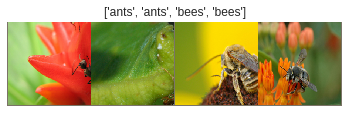

In [12]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.grid(False)
    plt.tick_params(labelbottom="off",bottom="off")    # x軸の削除
    plt.tick_params(labelleft="off",left="off")    # y軸の削除
    if title is not None:
        plt.title(title)

images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())  # torch.Size([4, 3, 224, 224]) torch.Size([4])
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

## モデルの訓練用の関数

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

## 予測の可視化用関数

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 最初から学習

In [0]:
# 組み込みのモデルを読み込み
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features

# 最終の全結合層を書き換える
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 学習の実行

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7170 Acc: 0.5615
val Loss: 1.0494 Acc: 0.4510
Epoch 1/24
----------
train Loss: 0.7220 Acc: 0.5697
val Loss: 0.6234 Acc: 0.6863
Epoch 2/24
----------
train Loss: 0.8657 Acc: 0.5615
val Loss: 1.1389 Acc: 0.5621
Epoch 3/24
----------
train Loss: 0.8698 Acc: 0.5246
val Loss: 0.7278 Acc: 0.5490
Epoch 4/24
----------
train Loss: 0.6882 Acc: 0.6025
val Loss: 0.6720 Acc: 0.6405
Epoch 5/24
----------
train Loss: 0.7493 Acc: 0.6270
val Loss: 0.7395 Acc: 0.6732
Epoch 6/24
----------
train Loss: 0.6859 Acc: 0.5943
val Loss: 0.7014 Acc: 0.6863
Epoch 7/24
----------
train Loss: 0.7437 Acc: 0.5738
val Loss: 0.6427 Acc: 0.6601
Epoch 8/24
----------
train Loss: 0.6376 Acc: 0.6352
val Loss: 0.7551 Acc: 0.5817
Epoch 9/24
----------
train Loss: 0.5915 Acc: 0.7008
val Loss: 0.7079 Acc: 0.6405
Epoch 10/24
----------
train Loss: 0.5583 Acc: 0.7172
val Loss: 0.6911 Acc: 0.6209
Epoch 11/24
----------
train Loss: 0.5782 Acc: 0.7213
val Loss: 0.7032 Acc: 0.6732
Epoch 12/24
--

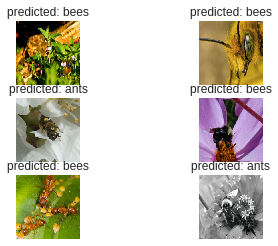

In [18]:
visualize_model(model_ft)

## 学習済みモデルからのファインチューニング

In [19]:
# 学習済みモデルの読み込み
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 最終の全結合層を書き換える
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 22894981.17it/s]


### 学習の実行

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5506 Acc: 0.7418
val Loss: 0.2545 Acc: 0.8889
Epoch 1/24
----------
train Loss: 0.4373 Acc: 0.8320
val Loss: 0.2412 Acc: 0.8954
Epoch 2/24
----------
train Loss: 0.4789 Acc: 0.8074
val Loss: 0.5972 Acc: 0.8170
Epoch 3/24
----------
train Loss: 0.5009 Acc: 0.8115
val Loss: 0.2171 Acc: 0.9216
Epoch 4/24
----------
train Loss: 0.4469 Acc: 0.8074
val Loss: 0.2992 Acc: 0.8627
Epoch 5/24
----------
train Loss: 0.3728 Acc: 0.8320
val Loss: 0.4145 Acc: 0.8824
Epoch 6/24
----------
train Loss: 0.4141 Acc: 0.8443
val Loss: 0.2577 Acc: 0.8889
Epoch 7/24
----------
train Loss: 0.3681 Acc: 0.8320
val Loss: 0.2021 Acc: 0.9281
Epoch 8/24
----------
train Loss: 0.3244 Acc: 0.8852
val Loss: 0.1808 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.1952 Acc: 0.9467
val Loss: 0.1886 Acc: 0.9150
Epoch 10/24
----------
train Loss: 0.3703 Acc: 0.8607
val Loss: 0.2360 Acc: 0.8889
Epoch 11/24
----------
train Loss: 0.2618 Acc: 0.8811
val Loss: 0.1754 Acc: 0.9281
Epoch 12/24
--

In [0]:
visualize_model(model_ft)